In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("data/athlete_events.csv")
# drop cols which have NA for suggusted features
df = df.dropna(subset=['Age', 'Height', 'Weight', 'Sex'])
df.groupby(['Sport']).size().reset_index(name='Count').sort_values("Count", ascending=False).iloc[:10,:]

,Sport,Count
3,Athletics,32374
44,Swimming,18776
22,Gymnastics,18271
33,Rowing,7790
14,Cycling,7775
12,Cross Country Skiing,7529
37,Shooting,7260
17,Fencing,6537
0,Alpine Skiing,6322
11,Canoeing,5550


In [3]:
df_pred_events = df[df["Sport"].isin(["Swimming", "Gymnastics", "Rowing", "Cycling", "Fencing"])]
df_pred_events = df_pred_events[["Age", "Height", "Weight", "Sex", "Sport"]]

df_pred_events["Sex_F"] = np.where(df_pred_events['Sex'] == "F", 1, 0)
df_pred_events["Sex_M"] = np.where(df_pred_events['Sex'] == "M", 1, 0)
df_pred_events = df_pred_events.drop('Sex', axis=1)

df_pred_events.head()

,Age,Height,Weight,Sport,Sex_F,Sex_M
41,28.0,175.0,64.0,Gymnastics,0,1
42,28.0,175.0,64.0,Gymnastics,0,1
43,28.0,175.0,64.0,Gymnastics,0,1
44,28.0,175.0,64.0,Gymnastics,0,1
45,28.0,175.0,64.0,Gymnastics,0,1


In [4]:
def scale(x):
    return (x - min(x)) / (max(x) - min(x))

df_pred_events[["Age", "Height", "Weight"]] = df_pred_events[["Age", "Height", "Weight"]].apply(scale)

# split into features and test train split
y = df_pred_events["Sport"]
X = df_pred_events[["Age", "Height", "Weight", "Sex_F", "Sex_M"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# train model
mlp = MLPClassifier(hidden_layer_sizes=(200, 100, 50), activation="relu", solver="adam", max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# see how model performs
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.6622992392223161


In [6]:
results = {"labels":y_test, "predicted":y_pred}
df_results = pd.DataFrame(results)

df_results["is_correct"] = df_results["labels"] == df_results['predicted']
df_counts = df_results.groupby(["labels", "is_correct"]).size().reset_index(name="count")

total_counts = df_results.groupby('labels').size()
correct_counts = df_results[df_results['labels'] == df_results['predicted']].groupby("labels").size()

# Compute the percentage of correct predictions
accuracy = (correct_counts / total_counts * 100).fillna(0).reset_index()
accuracy.columns = ['correct_label', 'accuracy_percentage']

accuracy

,correct_label,accuracy_percentage
0,Cycling,28.034301
1,Fencing,27.450980
2,Gymnastics,91.616106
3,Rowing,60.607940
4,Swimming,73.253333


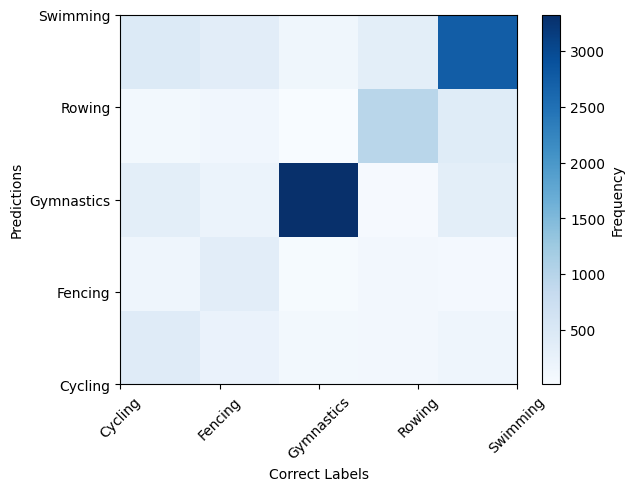

In [7]:
import matplotlib.pyplot as plt

sorted_labels = np.sort(df_results["labels"].unique())

index_dict = {label: i for i, label in enumerate(sorted_labels)}

df_results["labels_indexed"] = df_results["labels"].map(index_dict)
df_results["predictions_indexed"] = df_results["predicted"].map(index_dict)

plt.hist2d(df_results["labels_indexed"], df_results["predictions_indexed"], bins=5, cmap=plt.cm.Blues)


plt.xticks(ticks=np.arange(len(sorted_labels)), labels=sorted_labels, rotation=45)
plt.yticks(ticks=np.arange(len(sorted_labels)), labels=sorted_labels)

# Add labels and title
plt.xlabel('Correct Labels')
plt.ylabel('Predictions')

# Add a colorbar to show the frequency scale
plt.colorbar(label='Frequency')

# Show the plot
plt.show()